## Enhanced Agentic PageRAG with Elegant Schema Architecture

#### Real-World Applications:
1. **Financial Analysis**: SEC filings (10-K, 10-Q) with automatic company/year/section detection
2. **Legal Research**: Contracts and case law with jurisdiction/date/clause filtering  
3. **Medical Records**: Patient documents with date/provider/department filters
4. **Enterprise Docs**: Multi-project knowledge base with org/dept/category filters
5. **Research Papers**: Academic search with author/year/topic/section filters

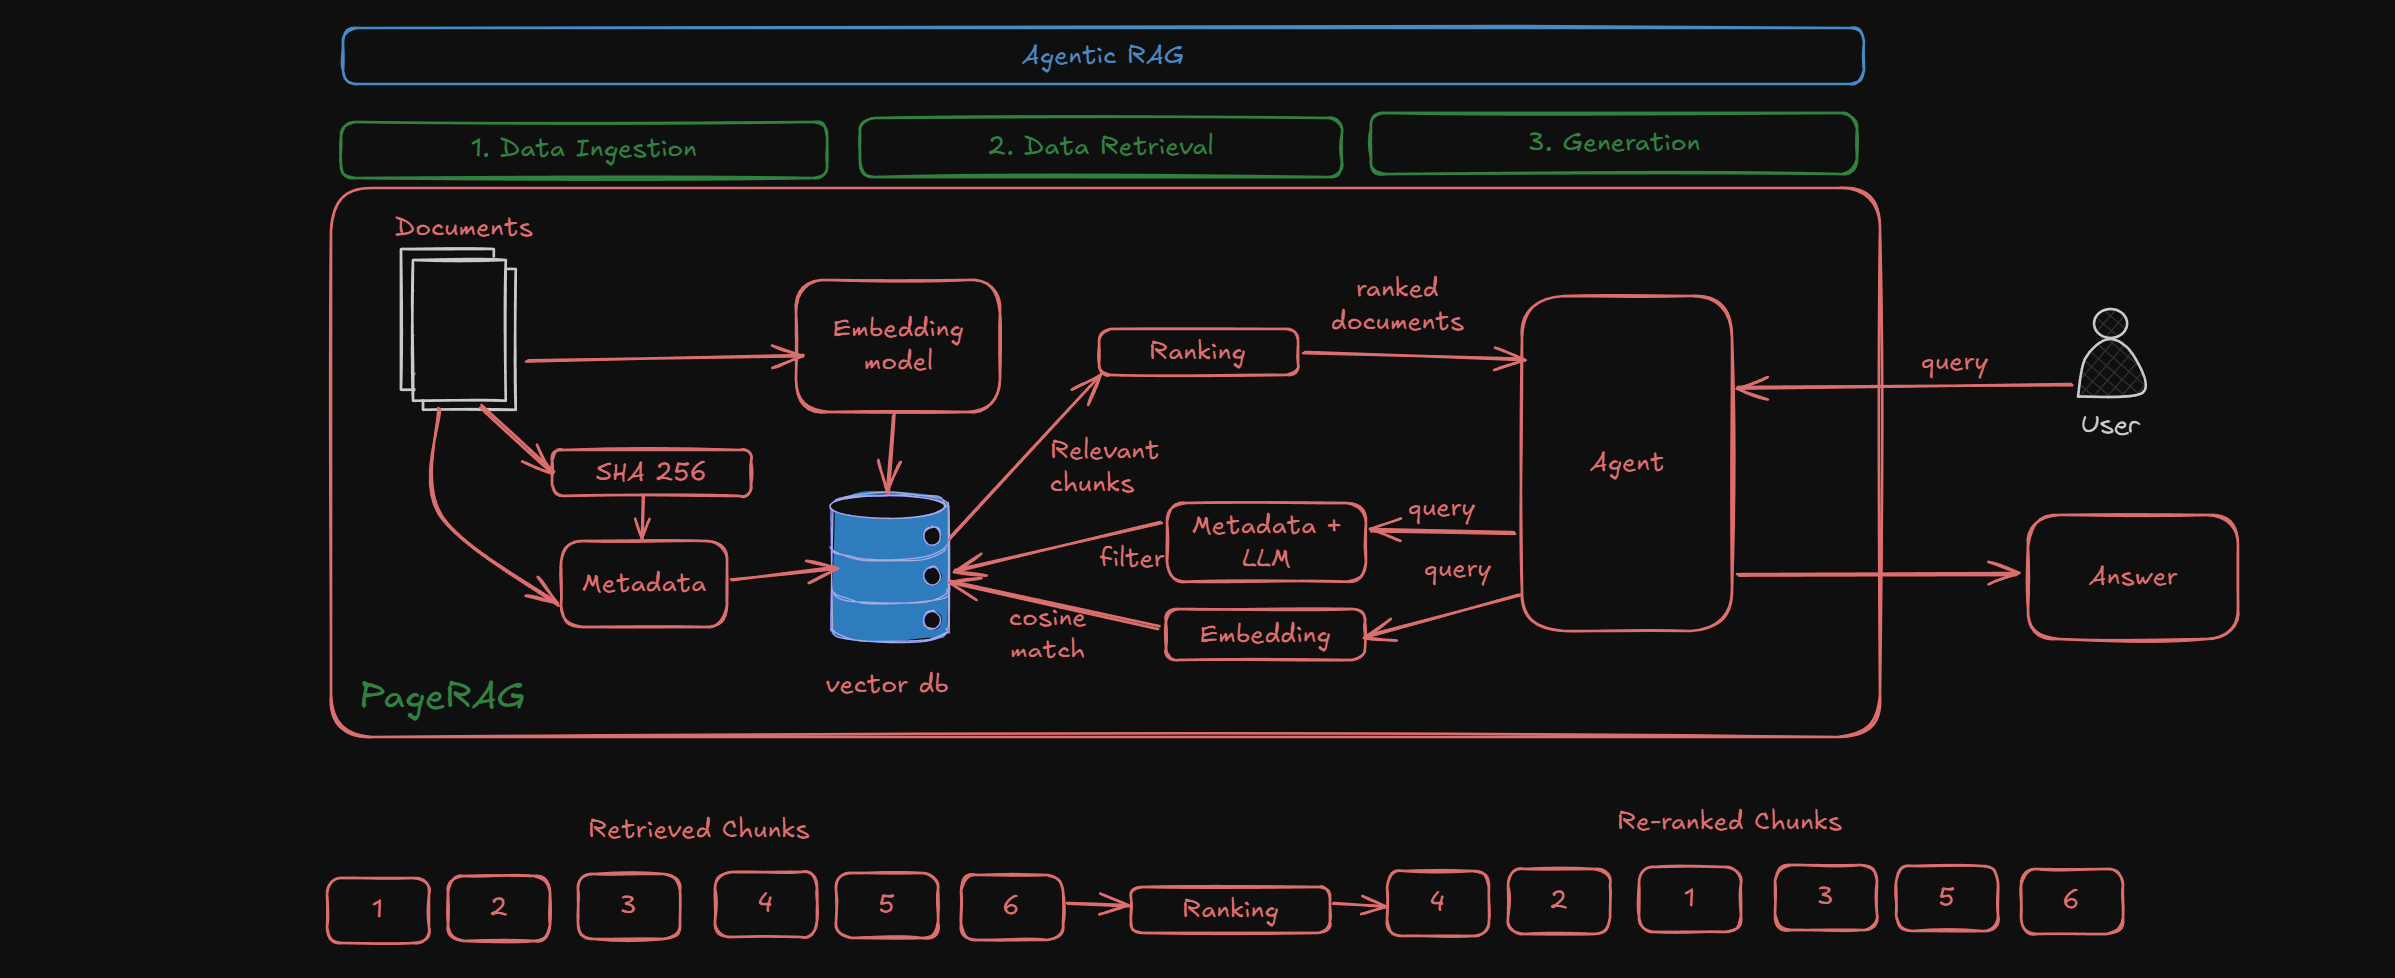

In [1]:
# ollama pull qwen3
# ollama pull gpt-oss llama3.2 
# ollama pull qwen3:0.6b
# ollama pull nomic-embed-text


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing_extensions import TypedDict, Annotated
import operator
import os

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool

# render markdown content in Notebook
from IPython.display import display, Markdown

from scripts import utils

In [4]:
# =============================================================================
# Configuration
# =============================================================================

LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"

llm = ChatOllama(
        model=LLM_MODEL,
        base_url=BASE_URL
    )

In [5]:
utils.extract_filters("what is amazon's cashflow in 2024")

{'company_name': 'amazon', 'fiscal_year': 2024}

In [6]:
# =============================================================================
# State Definition
# =============================================================================

class AgentState(TypedDict):
    messages: Annotated[list, operator.add]

### Retriever Tool

In [7]:
@tool
def retrieve_docs(query:str, k=5):
    """
    Retrieve relevant financial documents from ChromaDB.
    Extracts filters from query and retrieves matching documents.

    Args:
        query: The search query (e.g., "What was Amazon's revenue in Q2 2025?")
        k: Number of documents to retrieve. generally prefer 5 docs

    Returns:
        Retrieved documents with metadata as formatted string
    """
    print(f"\n[TOOL] retrieve_docs called")
    print(f"[QUERY] {query}")

    filters = utils.extract_filters(query)
    ranking_keywords = utils.generate_ranking_keywords(query)
    results = utils.search_docs(query, filters, ranking_keywords, k=k)

    # rank retrieved docs
    docs = utils.rank_documents_by_keywords(results, ranking_keywords, k=k)

    print(f"[RETRIEVED] {len(docs)} documents")

    # format extracted docs or chunks
    if len(docs)==0:
        return f"No ducuments found for the query: '{query}'. Try rephrasing query or use different filter."
    
    # final format
    # --- Document {i} ---
    retrieved_text = []
    for i, doc in enumerate(docs, 1):
        doc_text = [f"--- Document {i} ---"]

        # add all metadata
        for key, value in doc.metadata.items():
            doc_text.append(f"{key}: {value}")

        # add content
        doc_text.append(f"\nContent:\n{doc.page_content}")

        text = "\n".join(doc_text)
        retrieved_text.append(text)

    retrieved_text = "\n".join(retrieved_text)

    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/retrieved_reranked_docs.md", "w", encoding='utf-8') as f:
        f.write(retrieved_text)

    return retrieved_text


In [8]:
query = "what is amazon's revenue in 2024?"
result = retrieve_docs.invoke(query)


[TOOL] retrieve_docs called
[QUERY] what is amazon's revenue in 2024?
   [1] Doc 2: score=18.4644
   [2] Doc 4: score=18.3429
   [3] Doc 3: score=17.5404
   [4] Doc 1: score=13.5772
   [5] Doc 0: score=13.1420
[RETRIEVED] 5 documents


### Agent Node

In [9]:
# =============================================================================
# Agent Node
# =============================================================================

def agent_node(state: AgentState):

    messages = state['messages']

    tools = [retrieve_docs]
    llm_with_tools = llm.bind_tools(tools)

    system_prompt = """You are a financial document analysis assistant with access to a document retrieval tool.

                CRITICAL RULES:
                1. ALWAYS use the retrieve_docs tool first - NEVER answer from memory
                2. You MUST call the tool before providing any financial information
                3. Answer ONLY based on the retrieved documents
                4. If documents don't contain the answer, clearly state that

                WORKFLOW FOR SIMPLE QUESTIONS:
                Step 1: Call retrieve_docs tool with the user's question
                Step 2: Wait for the tool results
                Step 3: Analyze the retrieved documents
                Step 4: Provide answer with citations (company, year, quarter, page)

                WORKFLOW FOR COMPLEX/COMPARISON QUESTIONS:
                Step 1: Break down the question into sub-questions
                Example: "Compare Amazon and Google revenue" -> 
                - Sub-question 1: "Amazon revenue"
                - Sub-question 2: "Google revenue"

                Step 2: Call retrieve_docs for EACH sub-question separately
                - First call for Amazon
                - Wait for results
                - Second call for Google
                - Wait for results

                Step 3: Analyze all retrieved documents

                Step 4: Present comparison in TABLE format:
                | Metric | Company A | Company B |
                |--------|-----------|-----------|
                | Revenue | $X | $Y |

                ANSWER FORMATTING (Use Markdown):
                - Use **headings** (##, ###) for sections
                - Use paragraphs for detailed findings and reasonings
                - Use **bullet points** for lists
                - Use **tables** for comparisons and structured data
                - Use **bold** for emphasis on key metrics
                - Cite sources: (Company: X, Year: Y, Quarter: Z, Page: N)

                EXAMPLES:

                Example 1 - Simple Question:
                User: "What was Amazon's revenue in Q2 2025?"
                You: [Call tool] -> [Analyze docs] -> 
                "## Amazon Q2 2025 Revenue

                Amazon's revenue for Q2 2025 was **$XXX billion**

                **Source:** Amazon, 2025, Q2, Page 5"

                Example 2 - Comparison Question:
                User: "Compare Amazon and Google revenue"
                You: [Call tool for Amazon] -> [Call tool for Google] -> [Analyze both] ->
                "## Revenue Comparison

                | Company | Revenue | Year | Quarter |
                |---------|---------|------|---------|
                | Amazon  | $XXX B  | 2025 | Q2      |
                | Google  | $YYY B  | 2025 | Q2      |

                **Analysis:**
                - Amazon's revenue was higher by $ZZZ billion
                - Google showed XX% growth

                **Sources:**
                - Amazon: 2025, Q2, Page 5
                - Google: 2025, Q2, Page 8"

                Example 3 - Multi-part Question:
                User: "What are Amazon's revenue, profit, and cash flow?"
                You: [Call tool] -> [Analyze docs] ->
                "## Amazon Financial Metrics

                ### Revenue
                - Q2 2025: $XXX billion

                ### Profit  
                - Q2 2025: $YYY billion

                ### Cash Flow
                - Q2 2025: $ZZZ billion

                **Source:** Amazon, 2025, Q2, Pages 5-7"

                REMEMBER:
                - ALWAYS call the tool first
                - Break complex questions into sub-questions
                - Use tables for comparisons
                - Format answers in detailed Markdown
                - Always cite sources
                - If no relevant documents are found, try with different filters."""
    
    system_msg = SystemMessage(system_prompt)

    messages = [system_msg] + messages

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[AGENT] Responding...")


    return {'messages': [response]}



### Routing

In [10]:
def should_continue(state: AgentState):
    last = state['messages'][-1]
    
    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    

    else:
        return END

### Graph Creation

In [11]:
def create_agent():

    builder = StateGraph(AgentState)

    builder.add_node('agent', agent_node)
    builder.add_node('tools', ToolNode([retrieve_docs]))

    # create edges
    builder.add_edge(START, 'agent')
    builder.add_conditional_edges('agent', should_continue, ['tools', END])
    builder.add_edge('tools', 'agent')

    graph = builder.compile()

    return graph

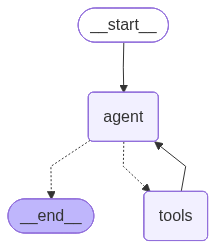

In [12]:
agent = create_agent()
agent

In [13]:
query = "what is the amazon's revenue in 2023?"

result = agent.invoke({'messages': [HumanMessage(query)]})

[AGENT] called Tool retrieve_docs with args {'k': 5, 'query': "Amazon's revenue 2023"}

[TOOL] retrieve_docs called
[QUERY] Amazon's revenue 2023
   [1] Doc 0: score=16.6855
   [2] Doc 2: score=14.7532
   [3] Doc 4: score=13.5543
   [4] Doc 3: score=13.3328
   [5] Doc 1: score=13.3215
[RETRIEVED] 5 documents
[AGENT] Responding...


In [14]:
result

{'messages': [HumanMessage(content="what is the amazon's revenue in 2023?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-14T11:41:32.288574Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3095739600, 'load_duration': 66762900, 'prompt_eval_count': 1069, 'prompt_eval_duration': 116705400, 'eval_count': 314, 'eval_duration': 2849446300, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--3841c264-fb40-40b9-b323-6d3c68f9fee3-0', tool_calls=[{'name': 'retrieve_docs', 'args': {'k': 5, 'query': "Amazon's revenue 2023"}, 'id': '15a0043a-7686-40fe-b884-df681aa0b076', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1069, 'output_tokens': 314, 'total_tokens': 1383}),
  ToolMessage(content="--- Document 1 ---\npage: 25\nsource_file: amazon 10-k 2023.pdf\nfile_hash: 6e5549c7b20b0fbc5f482397070a1e85cbf8643c801ff570903f52366b11154f\ndoc_type: 10-k\nfiscal_year: 2023\

In [19]:
result['messages'][-1].pretty_print()

display(Markdown(result['messages'][-1].content))

================================== Ai Message ==================================

## Amazon's 2023 Revenue

Amazon's total revenue (net sales) for 2023 was **$574.785 billion**.

This figure is derived from the "Net Sales by Groups of Similar Products and Services" table in the 10-K filing, which consolidates all revenue streams:

- **Online stores**: $231.872 billion  
- **Physical stores**: $20.030 billion  
- **Third-party seller services**: $140.053 billion  
- **Advertising services**: $46.906 billion  
- **Subscription services**: $40.209 billion  
- **AWS**: $90.757 billion  
- **Other**: $4.958 billion  

**Source:** Amazon, 2023, 10-K, Page 43 (Section: Revenue)


## Amazon's 2023 Revenue

Amazon's total revenue (net sales) for 2023 was **$574.785 billion**.

This figure is derived from the "Net Sales by Groups of Similar Products and Services" table in the 10-K filing, which consolidates all revenue streams:

- **Online stores**: $231.872 billion  
- **Physical stores**: $20.030 billion  
- **Third-party seller services**: $140.053 billion  
- **Advertising services**: $46.906 billion  
- **Subscription services**: $40.209 billion  
- **AWS**: $90.757 billion  
- **Other**: $4.958 billion  

**Source:** Amazon, 2023, 10-K, Page 43 (Section: Revenue)

In [20]:
query = "what is the revenue of amazon's and google in 2023?"

result = agent.invoke({'messages': [HumanMessage(query)]})

display(Markdown(result['messages'][-1].content))

[AGENT] called Tool retrieve_docs with args {'k': 5, 'query': 'Amazon revenue 2023'}
[AGENT] called Tool retrieve_docs with args {'k': 5, 'query': 'Google revenue 2023'}

[TOOL] retrieve_docs called
[QUERY] Amazon revenue 2023

[TOOL] retrieve_docs called
[QUERY] Google revenue 2023
   [1] Doc 0: score=16.6855
   [2] Doc 2: score=14.7532
   [3] Doc 4: score=13.5543
   [4] Doc 3: score=13.3328
   [5] Doc 1: score=13.3215
[RETRIEVED] 5 documents
   [1] Doc 1: score=16.4724
   [2] Doc 2: score=13.8861
   [3] Doc 3: score=11.0770
   [4] Doc 4: score=10.7541
   [5] Doc 0: score=6.5917
[RETRIEVED] 5 documents
[AGENT] Responding...


## Revenue Comparison: Amazon vs. Google in 2023

| **Metric**               | **Amazon**       | **Google**        |
|--------------------------|------------------|-------------------|
| **Total Revenue (2023)** | **$574.785 billion** | **$307.394 billion** |
| **Source**               | Amazon 10-K 2023, Page 5 | Google 10-K 2023, Page 87 |

### **Analysis**
- **Amazon** reported **$574.785 billion** in total revenue for 2023, driven by its diversified segments including retail, AWS, and third-party services (see **Table 5** in the 10-K).  
- **Google** (Alphabet Inc.) reported **$307.394 billion** in total revenue for 2023, split across segments like Google Services, Google Cloud, and Other Bets (see **Note 15** in the 10-K).  

### **Key Context**
- Amazon's revenue is significantly higher due to its broader retail and logistics ecosystem, while Google's revenue is concentrated in advertising and cloud services.  
- Both figures are derived from their respective **10-K filings** for the fiscal year ended December 31, 2023.  

**Sources:**  
- Amazon: 2023, Page 5 (Net Sales Table)  
- Google: 2023, Page 87 (Note 15: Segments and Geographic Areas)